In [1]:
import os

os.environ["FIREWORKS_API_KEY"] = "fw_3ZcezLdtCxoWnqVZ2rrqU6do"
os.environ["MISTRAL_API_KEY"] = "pML2mc6ULk9DOp0UOT02KZvHh3jyitP5"
os.environ["AZURE_OPENAI_API_KEY"] = "ae503f6efa1a4211aa89b74a501a9551"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://genai4e.openai.azure.com/"

In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo",  # or your deployment
    api_version="2023-03-15-preview",  # or your api version
    temperature=0.7,
    max_tokens=700,
    # other params...
)

# from langchain_ollama import ChatOllama

# llm = ChatOllama(model="llama3.1", num_predict=1000, temperature=0.7)

# from langchain_mistralai import ChatMistralAI

# llm = ChatMistralAI(
#     model="mistral-large-2407",
#     temperature=0.7,
#     max_retries=2,
#     max_tokens=700,
#     # other params...
# )

# from langchain_fireworks import ChatFireworks

# llm = ChatFireworks(
#     model="accounts/fireworks/models/llama-v3p1-70b-instruct",
#     temperature=1,
#     max_tokens=1000,
#     max_retries=2,
#     # other params...
# )

In [3]:
from template_utils import categories_template, map_categories_template, get_schema, generate_QA_template
from parse_utils import Categories, Pairs
from typing import Annotated, TypedDict, List


inital_chain = categories_template() | llm.with_structured_output(Categories)
map_chain = map_categories_template() | llm.with_structured_output(Categories)
generate_QA_chain = generate_QA_template() | llm.with_structured_output(Pairs)

In [4]:
import operator
from typing_extensions import TypedDict
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    schema: str
    categories: Annotated[List, operator.add]
    category: str
    final_categories: List
    question_cypher_pairs: Annotated[List, operator.add]
    times: int
    n_category: int
    n_pair: int


async def generate_category(state: State):
    response = await inital_chain.ainvoke({"schema": state["schema"], "n_category": state["n_category"]})
    return {"categories": response["categories"]}


def map_categories(state: State):
    return [
        Send("generate_category", {"schema": state["schema"], "n_category": state["n_category"]}) for _ in range(state["times"])
    ]


async def final_category(state: State):
    response = await map_chain.ainvoke({"categories": state["categories"]})
    return {"final_categories": response["categories"]}


def map_generate_QA(state: State):
    return [
        Send("generate_QA", {"category": category, 
                             "n_pair": state["n_pair"], 
                             "schema": state["schema"]}) for category in state["final_categories"]
    ]

async def generate_QA(state: State):
    response = await generate_QA_chain.ainvoke({"category": state["category"], 
                                                "n_pair": state["n_pair"], 
                                                "schema": state["schema"]})
    return response


async def final_result(state: State):
    return {"question_cypher_pairs": state["question_cypher_pairs"]}

In [5]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate_category", generate_category)
graph_builder.add_node("final_category", final_category)
graph_builder.add_node("generate_QA", generate_QA)
graph_builder.add_node("final_result", final_result)
graph_builder.add_conditional_edges(START, map_categories, ["generate_category"])
graph_builder.add_edge("generate_category", "final_category")
graph_builder.add_conditional_edges("final_category", map_generate_QA, ["generate_QA"])
graph_builder.add_edge("generate_QA", "final_result")
graph_builder.add_edge("final_result", END)
graph = graph_builder.compile()

# graph_builder = StateGraph(State)
# graph_builder.add_node("generate_category", generate_category)
# graph_builder.add_node("final_categories", final_categories)
# graph_builder.add_conditional_edges(START, map_categories, ["generate_category"])
# graph_builder.add_edge("generate_category", "final_categories")
# graph_builder.add_edge("final_categories", END)
# graph = graph_builder.compile()

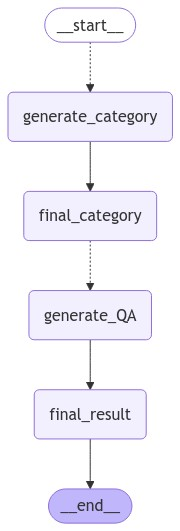

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
async for event in graph.astream({"schema": get_schema(), "times": 2, "n_pair": 2, "n_category":2}):
    print(event)

{'generate_category': {'categories': [{'category': "Person's Education and Work Experience", 'description': "Questions about a person's education background and their work experience."}, {'category': "Person's Skills and Achievements", 'description': "Questions about a person's skills and achievements."}]}}
{'generate_category': {'categories': [{'category': 'Career Development', 'description': "Questions about a person's career path, including their work experience, skills, and education."}, {'category': 'Achievements and Expertise', 'description': "Questions about a person's achievements, such as publications, certifications, and relevant skills."}]}}
{'final_category': {'final_categories': [{'category': 'Person', 'description': 'Questions about a person'}, {'category': 'Person', 'description': 'Questions about a person'}]}}
{'generate_QA': {'question_cypher_pairs': [{'question': 'What is the name of the person who worked at Google?', 'cypher': 'MATCH (p:Person)-[:Worked_at]->(wp:Work

In [9]:
from pprint import pprint

pprint(event["final_result"]["question_cypher_pairs"])

[{'cypher': 'MATCH (p:Person {name: "John"})-[:Worked_at]->(w:WorkPlace) '
            'RETURN w.NAME AS WorkplaceName',
  'question': 'What is the name of the workplace where John worked?'},
 {'cypher': 'MATCH (pos:Position {NAME: "Data '
            'Scientist"})-[:Relevant_to]->(s:Skills) RETURN pos.NAME AS '
            'PositionName, s.NAME AS SkillName, s.category AS SkillCategory',
  'question': 'What are the skills that are relevant to the position of Data '
              'Scientist?'},
 {'cypher': 'MATCH (p:Person)-[:Worked_at]->(wp:WorkPlace {NAME: ',
  'question': 'What is the name of the person who worked at Google?'},
 {'cypher': 'MATCH (pos:Position {NAME: ',
  'question': 'What are the skills that are relevant to the position of Data '
              'Scientist?'}]


In [11]:
import jsonlines

with jsonlines.open("result.jsonl", "w") as writer:
    writer.write_all(event["final_result"]["question_cypher_pairs"])